Agent Catalog aims to simplify your agent application development process by i) providing a consolidated view of versioned tools and prompts used by your agents and ii) providing application traceability via logging.


## Setup OpenAI


In [1]:
import dotenv

dotenv.load_dotenv(dotenv.find_dotenv(usecwd=True))

True

In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if os.environ.get(var) is None:
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")

In [3]:
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)

## Setup Agent Catalog

In [4]:
from agentc.catalog import Catalog

catalog = Catalog()
application_span = catalog.Span(
    name="My Researcher Application",
)

## Build Research Agent

In [5]:
from agentc_langgraph.agent import ReActAgent
from langchain_core.messages import SystemMessage
from langgraph.graph import END
from langgraph.types import Command


def get_next_node(last_message, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent has decided that the work is done.
        return END
    return goto


class ResearchAgent(ReActAgent):
    def __init__(self, span):
        super().__init__(catalog=catalog, prompt_name="researcher_agent", span=span, chat_model=llm)

    def _invoke(self, span, state, config):
        agent = self.create_react_agent(span)
        result = agent.invoke(state)
        goto = get_next_node(result["messages"][-1], "chart_generator")
        result["messages"][-1] = SystemMessage(content=result["messages"][-1].content, name="researcher")
        return Command(
            update={
                # share internal message history of research agent with other agents
                "messages": result["messages"],
            },
            goto=goto,
        )

## Build Charter Agent

In [6]:
class CharterAgent(ReActAgent):
    def __init__(self, span):
        super().__init__(catalog=catalog, prompt_name="charter_agent", span=span, chat_model=llm)

    def _invoke(self, span, state, config):
        agent = self.create_react_agent(span)
        result = agent.invoke(state)
        goto = get_next_node(result["messages"][-1], "researcher")
        result["messages"][-1] = SystemMessage(content=result["messages"][-1].content, name="researcher")
        return Command(
            update={
                # share internal message history of research agent with other agents
                "messages": result["messages"],
            },
            goto=goto,
        )

## Build The Graph

In [7]:
from agentc_langgraph.agent import State
from agentc_langgraph.graph import GraphRunnable
from langgraph.graph import START
from langgraph.graph import StateGraph


class MyResearcherApplication(GraphRunnable):
    def __init__(self):
        super().__init__(catalog=catalog, span=application_span)

    def compile(self):
        workflow = StateGraph(State)
        workflow.add_node("researcher", ResearchAgent(span=self.span))
        workflow.add_node("chart_generator", CharterAgent(span=self.span))
        workflow.add_edge(START, "researcher")
        return workflow.compile()


graph = MyResearcherApplication()

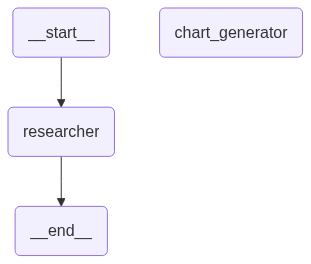

In [8]:
from IPython.display import Image
from IPython.display import display

# Note: the researcher *explicitly* sends state to the chart_generator in this example.
display(Image(graph.get_graph().draw_mermaid_png()))

## Run Our Graph

Sorry, need more steps to process this request.
----


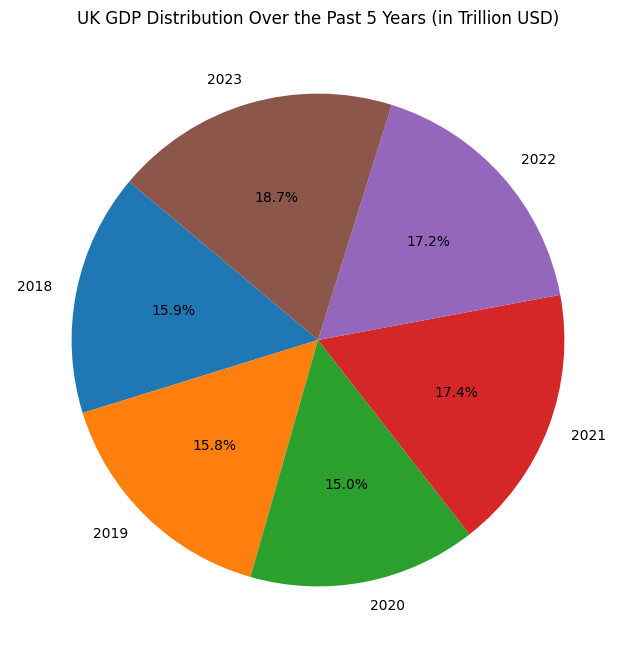

In [ ]:
user_input = "First, get the UK's GDP over the past 5 years, then give a brief summary of it along with a pie chart. Once you make the chart, finish."
application_span.log(content={"kind": "user", "value": user_input})
events = graph.stream(
    {"messages": [("user", user_input)], "is_last_step": False, "previous_node": None},
    # Maximum number of steps to take in the graph
    {"recursion_limit": 10},
)

for event in events:
    for key in event:
        for msg in event[key]["messages"]:
            if isinstance(msg, SystemMessage):
                print(msg.content)
                print("----")